In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [2]:
def plot_images(image, title):
    plt.title(title)
    plt.imshow(image, "gray")
    # plt.colorbar()

def step0_load_image(psf_image_filename):
    image = read_image(psf_image_filename)
    return image

def step1_get_psf(image, line_number, orientation):
    if orientation == "H":
        return image[line_number, :]
    else:
        return image[:, line_number]

def step9_get_mtf(psf):
    nn = psf.shape[0]
    freq = [i / nn for i in range(nn)]
    efl = 60
    px = 3.45
    # px = 2.74

    lppd = px/efl/1000 * 180/3.14159
    freq = np.array(freq)/lppd
    freq = np.array(freq)

    mtf = abs(fft(psf))
    mtf = mtf/mtf.max()
    return mtf, freq

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf

In [5]:
psf_files = {
    "ref_94": {
        "title": "ref_94",
        "psf_count": 8,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_01_crop.png",
                "h": 60,
                "v": 57,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_02_crop.png",
                "h": 58,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_03_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_04_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_05_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_06_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_07_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_94_3306us_0.06mw_08_crop.png",
                "h": 59,
                "v": 60,
            },            
        ]
    },
    
    "ref_140": {
        "title": "ref_140",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_01_crop.png",
                "h": 60,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_02_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_03_crop.png",
                "h": 60,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_04_crop.png",
                "h": 60,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_05_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_06_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_07_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/ref_140_3306us_0.06mw_08_crop.png",
                "h": 60,
                "v": 58,
            }
        ]
    },

    "s1_94": {
        "title": "s1_94",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_01_crop.png",
                "h": 61,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_02_crop.png",
                "h": 60,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_03_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_04_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_05_crop.png",
                "h": 60,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_06_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_07_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_08_crop.png",
                "h": 59,
                "v": 59,
            },
            {
                "filename": "./xcube_data/0720/s1_94_2604us_0.06mw_09_crop.png",
                "h": 59,
                "v": 60,
            }
        ]
    },

    "s1_100": {
        "title": "s1_100",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_01_crop.png",
                "h": 58,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_02_crop.png",
                "h": 60,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_03_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_04_crop.png",
                "h": 59,
                "v": 48,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_05_crop.png",
                "h": 60,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_06_crop.png",
                "h": 60,
                "v": 48,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_07_crop.png",
                "h": 61,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_08_crop.png",
                "h": 58,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_100_2604us_0.06mw_09_crop.png",
                "h": 59,
                "v": 57,
            }
        ]
    },

    "s1_105": {
        "title": "s1_105",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_01_crop.png",
                "h": 60,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_02_crop.png",
                "h": 61,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_03_crop.png",
                "h": 61,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_04_crop.png",
                "h": 61,
                "v": 47,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_05_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_06_crop.png",
                "h": 60,
                "v": 51,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_07_crop.png",
                "h": 60,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_08_crop.png",
                "h": 60,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_105_2699us_0.06mw_09_crop.png",
                "h": 59,
                "v": 56,
            }
        ]
    },
    
    "s1_110": {
        "title": "s1_110",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_01_crop.png",
                "h": 59,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_02_crop.png",
                "h": 59,
                "v": 46,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_03_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_04_crop.png",
                "h": 61,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_05_crop.png",
                "h": 61,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_06_crop.png",
                "h": 61,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_07_crop.png",
                "h": 61,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_08_crop.png",
                "h": 60,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_110_2604us_0.06mw_09_crop.png",
                "h": 59,
                "v": 57,
            }
        ]
    },
    
    "s1_115": {
        "title": "s1_115",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_01_crop.png",
                "h": 59,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_02_crop.png",
                "h": 59,
                "v": 48,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_03_crop.png",
                "h": 60,
                "v": 48,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_04_crop.png",
                "h": 59,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_05_crop.png",
                "h": 61,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_06_crop.png",
                "h": 60,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_07_crop.png",
                "h": 60,
                "v": 49,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_08_crop.png",
                "h": 60,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_115_2604us_0.06mw_09_crop.png",
                "h": 60,
                "v": 52,
            }
        ]
    },
    
    "s1_120": {
        "title": "s1_120",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_01_crop.png",
                "h": 60,
                "v": 57,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_02_crop.png",
                "h": 59,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_03_crop.png",
                "h": 60,
                "v": 52,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_04_crop.png",
                "h": 58,
                "v": 58,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_05_crop.png",
                "h": 59,
                "v": 56,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_06_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_07_crop.png",
                "h": 60,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_08_crop.png",
                "h": 61,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_120_2699us_0.06mw_09_crop.png",
                "h": 60,
                "v": 53,
            }
        ]
    },
    
    "s1_125": {
        "title": "s1_125",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_01_crop.png",
                "h": 59,
                "v": 57,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_02_crop.png",
                "h": 59,
                "v": 47,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_03_crop.png",
                "h": 61,
                "v": 53,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_04_crop.png",
                "h": 60,
                "v": 56,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_05_crop.png",
                "h": 60,
                "v": 51,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_06_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_07_crop.png",
                "h": 60,
                "v": 51,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_08_crop.png",
                "h": 59,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_125_2699us_0.06mw_09_crop.png",
                "h": 59,
                "v": 54,
            }
        ]
    },

    "s1_130": {
        "title": "s1_130",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_01_crop.png",
                "h": 60,
                "v": 56,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_02_crop.png",
                "h": 59,
                "v": 54,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_03_crop.png",
                "h": 58,
                "v": 57,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_04_crop.png",
                "h": 59,
                "v": 43,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_05_crop.png",
                "h": 59,
                "v": 46,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_06_crop.png",
                "h": 59,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_07_crop.png",
                "h": 60,
                "v": 51,
            },
            {
                "filename": "./xcube_data/0720/s1_130_2699us_0.06mw_08_crop.png",
                "h": 60,
                "v": 53,
            }
        ]
    },

    "s1_135": {
        "title": "s1_135",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_01_crop.png",
                "h": 60,
                "v": 55,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_02_crop.png",
                "h": 59,
                "v": 56,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_03_crop.png",
                "h": 61,
                "v": 62,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_04_crop.png",
                "h": 60,
                "v": 61,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_05_crop.png",
                "h": 60,
                "v": 50,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_06_crop.png",
                "h": 60,
                "v": 47,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_07_crop.png",
                "h": 58,
                "v": 47,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_08_crop.png",
                "h": 61,
                "v": 53,
            },
            {
                "filename": "./xcube_data/0720/s1_135_2699us_0.06mw_09_crop.png",
                "h": 61,
                "v": 53,
            }
        ]
    },

    "s1_140": {
        "title": "s1_140",
        "psf_count": 9,
        "psf_data": [
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_01_crop.png",
                "h": 60,
                "v": 62,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_02_crop.png",
                "h": 60,
                "v": 67,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_03_crop.png",
                "h": 61,
                "v": 61,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_04_crop.png",
                "h": 64,
                "v": 64,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_05_crop.png",
                "h": 60,
                "v": 45,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_06_crop.png",
                "h": 60,
                "v": 53,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_07_crop.png",
                "h": 60,
                "v": 60,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_08_crop.png",
                "h": 59,
                "v": 47,
            },
            {
                "filename": "./xcube_data/0720/s1_140_3603us_0.06mw_09_crop.png",
                "h": 60,
                "v": 53,
            }
        ]
    }
}

uint8


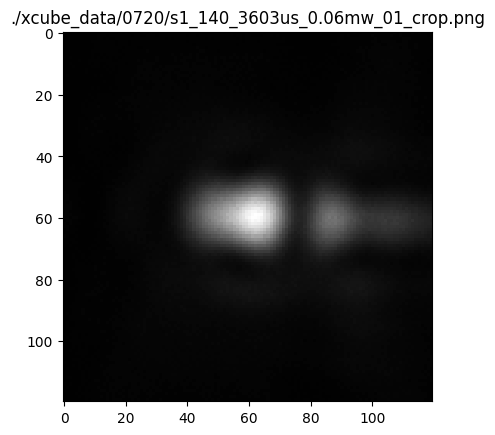

In [6]:
index = "s1_140"
psf_image_filename = psf_files[index]["psf_data"][0]["filename"]
h_line = psf_files[index]["psf_data"][0]["h"]
v_line = psf_files[index]["psf_data"][0]["v"]

image = step0_load_image(psf_image_filename)
print(image.dtype)
# plot_images(image, "s2_x50_x20_256us.png")
plot_images(image, psf_image_filename)

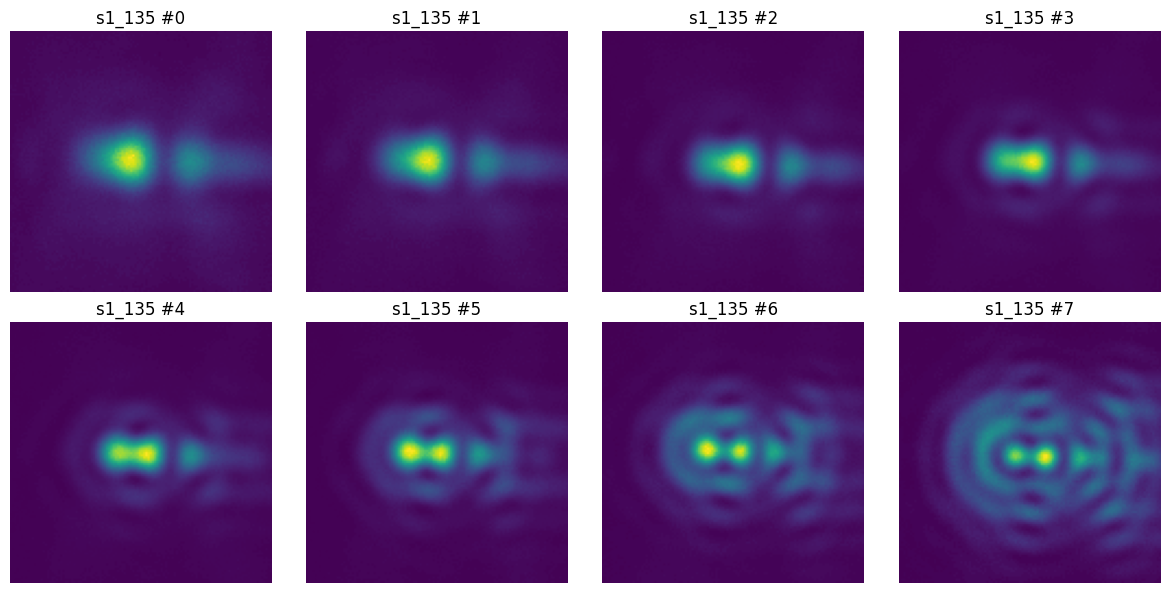

In [52]:
index = "s1_135"

title = psf_files[index]["title"]
psf_count = 8
psf_data = psf_files[index]["psf_data"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for idx, p_data in enumerate(psf_data):
    if idx < psf_count:
        psf_image_filename = p_data["filename"]
        h_line = p_data["h"]
        v_line = p_data["v"]
        image = step0_load_image(psf_image_filename)
    
    
        col = idx % 4
        row = idx // 4
        axs[row, col].imshow(image, cmap='viridis') # Display image3 in the bottom-left subplot
        axs[row, col].set_title(f"{title} #{idx}")
        axs[row, col].axis('off')

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the figure
plt.show()

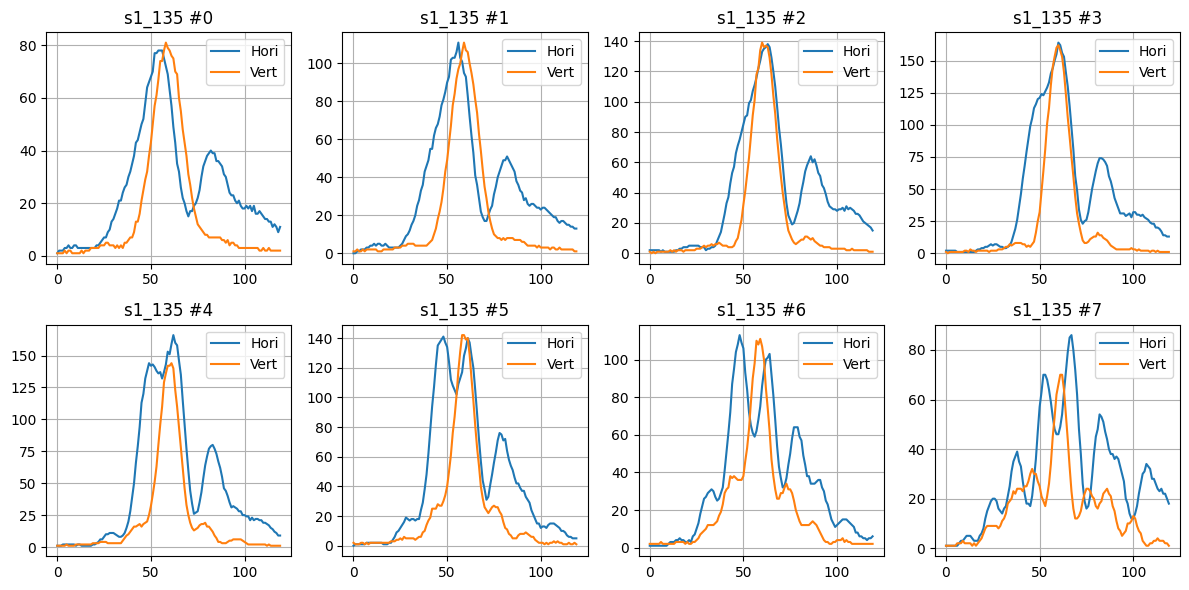

In [51]:
title = psf_files[index]["title"]
psf_count = 8
psf_data = psf_files[index]["psf_data"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for idx, p_data in enumerate(psf_data):
    if idx < psf_count:
        psf_image_filename = p_data["filename"]
        h_line = p_data["h"]
        v_line = p_data["v"]
        image = step0_load_image(psf_image_filename)
    
        psf_h = step1_get_psf(image, h_line, "H")
        # psf_h = step1_get_psf(image, 38, "H")
        
        psf_v = step1_get_psf(image, v_line, "V")
        # psf_v = step1_get_psf(image, 34, "V")
    
        col = idx % 4
        row = idx // 4
        axs[row, col].plot(psf_h, label="Hori")
        axs[row, col].plot(psf_v, label="Vert")
        axs[row, col].set_title(f"{title} #{idx}")
        axs[row, col].grid()
        axs[row, col].legend()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the figure
plt.show()

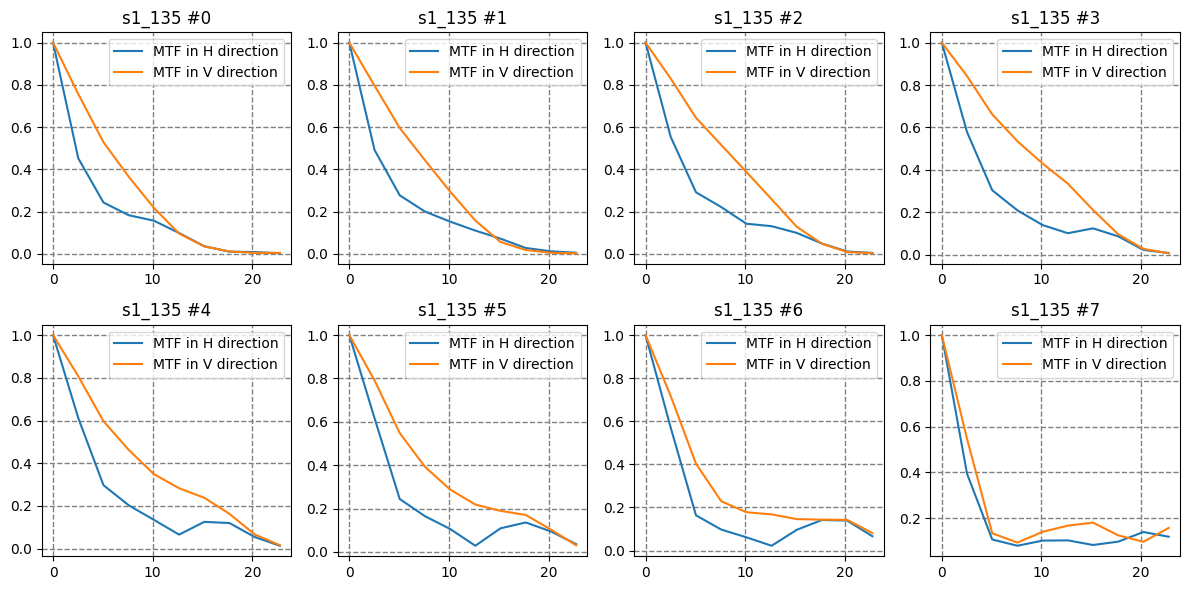

In [50]:
title = psf_files[index]["title"]
psf_count = 8
psf_data = psf_files[index]["psf_data"]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
freq_numbers = 10

for idx, p_data in enumerate(psf_data):
    if idx < psf_count:
        psf_image_filename = p_data["filename"]
        h_line = p_data["h"]
        v_line = p_data["v"]
        image = step0_load_image(psf_image_filename)
    
        psf_h = step1_get_psf(image, h_line, "H")
        # psf_h = step1_get_psf(image, 38, "H")
        
        psf_v = step1_get_psf(image, v_line, "V")
        # psf_v = step1_get_psf(image, 34, "V")
        
        mtf_h, freq_h = step9_get_mtf(psf_h)
        mtf_v, freq_v = step9_get_mtf(psf_v)
    
        col = idx % 4
        row = idx // 4
        axs[row, col].plot(freq_h[0:freq_numbers], mtf_h[0:freq_numbers], label='MTF in H direction', linestyle='-')
        axs[row, col].plot(freq_v[0:freq_numbers], mtf_v[0:freq_numbers], label='MTF in V direction', linestyle='-')
        axs[row, col].set_title(f"{title} #{idx}")
        axs[row, col].grid(color='gray', linestyle='--', linewidth=1)
        axs[row, col].legend()

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the figure
plt.show()

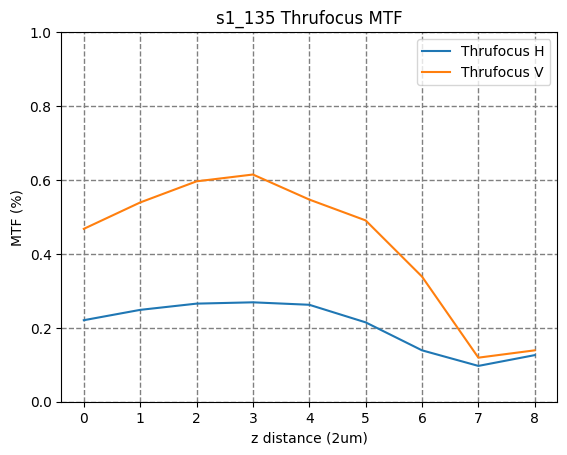

In [49]:
freq_numbers = 10

freq_val = 6

throufocus_h = []
throufocus_v = []
title = psf_files[index]["title"]
psf_files_names = psf_files[index]["psf_data"]
for psf in psf_files_names:
    psf_image_filename = psf["filename"]
    h_line = psf["h"]
    v_line = psf["v"]
    image = step0_load_image(psf_image_filename)
    psf_h = step1_get_psf(image, h_line, "H")
    psf_v = step1_get_psf(image, v_line, "V")

    mtf_h, freq_h = step9_get_mtf(psf_h)
    mtf_v, freq_v = step9_get_mtf(psf_v)
    # plt.plot(freq_v[0:freq_numbers], mtf_v[0:freq_numbers], label=f'{title} V #0', linestyle='--')
    # plt.plot(freq_h[0:freq_numbers], mtf_h[0:freq_numbers], label=f'{title} V #0', linestyle='-')

    freq, mtf = step10_get_mtf_interp(mtf_h, freq_h, freq_val)
    throufocus_h.append(mtf)
    freq, mtf = step10_get_mtf_interp(mtf_v, freq_v, freq_val)
    throufocus_v.append(mtf)

# plt.legend(loc='upper right')

plt.grid(color='gray', linestyle='--', linewidth=1)
plt.title(f"{title} Thrufocus MTF")
plt.plot(throufocus_h, label='Thrufocus H', linestyle='-')
plt.plot(throufocus_v, label='Thrufocus V', linestyle='-')
plt.xlabel("z distance (2um)")
plt.ylim(0, 1.0)
plt.ylabel("MTF (%)")
plt.legend(loc='upper right')